In [3]:
# start by loading data on the returns of the market portfolio and the risk-free rate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Signal Construction 

We have build portfolios using pre-constructed signals.

These signals are well known and therefore made them an unlikely source of large Sharpe ratios.

A quant fund aims to construct new characteristics based on new data or new ideas of how to combine the relevant public information.

So signal construction is ART and not science. There is no recipe here and each signal is constructed differently.

> We will have an overview of the main factors used in the industry--hold tight!

Now our goal is to learn one particular technique of factor construction that is based on past returns. I like to over this one because it enable you to do many different variations as we will see


## Momentum 

**Momentum** is the fact that stocks that have performed
**relatively** well in the past continue to perform
**relatively** well in the future, and stocks that have performed
**relatively** poorly, continue to perform **relatively**
poorly.

A Momentum investment or “relative strength”
strategy buys stocks which have performed relatively
well in the past and sells (shorts) stocks which have performed
relatively poorly.
Over the **1963-1990** time period, Jegadeesh and Titman
(1993) found that a strategy that ranked stocks based on
their past 6 months to a year returns, and bought the top
10% and shorted the bottom 10% based on this ranking,
produced abnormal returns of 12% per year.


Momentum portfolios bet on **cross-sectional** continuation. That is, in a stock did well relative to others in the recent past, the bet is that will continue to do better than the average going forward. 

In some ways momentum is the opposite of a value strategy , since value stocks are stocks that have had very low returns (how else they would be value?)

The difference is that value/growth focus on the valuation ratio as the signal of how low the price is. So the valuation ratio captures the entire history of returns (what is price if not the result of the historical returns). Momentum instead focus on the last 12 months. Recent, but not too recent. But there many versions of Momentum.


**Construction**

Here is how Daniel and Moskowitz construct their portfolios


>To form the momentum portfolios, **we first rank stocks based on their cumulative returns
from 12 months before to one month before the formation date (i.e., the t-12 to t-2-month
returns)**, we use a one month gap between the end of the ranking period and
the start of the holding period **to avoid the short-term reversals** documented by Jegadeesh
(1990) and Lehmann (1990). In particular we will focus on 10% and 90% quantiles of the signal distribution and will construct portfolios of all stocks that are in the bottom and top quintiles

1. Get monthly returns and market equity data for all us firms
2. Compute rolling cumulative 11 month returns
3. Lag signal by one month because rolling average includes current month.
    - This makes the signal cumulative returns form t-11 to t-1
    - It is a valid signal to bu at closing price of date t-1 to earn date t returns
    - But that is not yet what we want
4. Lag another month to be consistent with the  t-12 to t-2 month construction
5. Groups stocks according to this signal
6. Form portfolios

**1. Load return and market cap data by firm/date**

In [4]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *
from pandas.tseries.offsets import *

###################
conn=wrds.Connection() 


crsp = conn.raw_sql("""
                      select a.permno,a.permco, a.date, b.shrcd, b.exchcd,b.ticker,
                      a.ret, a.shrout, a.prc,a.retx
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/31/1990' and '12/31/2023'
                      and b.exchcd between 1 and 3
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

# construction of market equity

crsp=crsp[['permco','permno','ticker','date','ret','shrout','prc']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
crsp[['permco']]=crsp[['permco']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
# drop price and shareoustandng since we won't need it anymore
crsp=crsp.drop(['prc','shrout'], axis=1)
crsp_me=crsp.groupby(['date','permco'])['me'].sum().reset_index()


# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['date','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp=pd.merge(crsp, crsp_maxme, how='inner', on=['date','permco','me'])

# drop me column and replace with the sum me
crsp=crsp.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp=pd.merge(crsp, crsp_me, how='inner', on=['date','permco'])

# sort by permno and date and also drop duplicates
crsp=crsp.sort_values(by=['permno','date']).drop_duplicates()

crsp.head()


# this saves it
#crsp_m.to_pickle('../../assets/data/crspm2005_2020.pkl')



WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permco,permno,ticker,date,ret,me
2561,7953,10001,GFGC,1990-01-31,-0.018519,10156.125
2562,7953,10001,GFGC,1990-02-28,-0.006289,10092.250
2563,7953,10001,GFGC,1990-03-31,0.012658,10141.625
2564,7953,10001,GFGC,1990-04-30,0.000000,10141.625
2565,7953,10001,GFGC,1990-05-31,-0.012658,10013.250


**2. Construct rolling  cumulate the returns**

We need to construct the returns from t-11 to t:

$$1+r_{t-11,t}=(1+r_{t-11})(1+r_{t-10})..(1+r_{t-1})(1+r_{t})$$



We will now cumulate the returns of each asset on a rolling basis. As described in the procedure we wll look back for 11 months and compute the cumulative return in the period.


>**TIP** We will be grouping by `permno` and applying the `rolling()` operator, we will them apply the function `np.prod` which returns the product of the variables in the group. The ``groupby('permno')`` is what makes the rolling to be applied firm by firm

In [15]:
df=crsp.copy()
df['1+ret']=(df['ret']+1)
df=df.set_index(['date'])
temp=(df.groupby('permno')[['1+ret']]).rolling(window=11,min_periods=7).apply(np.prod, raw=True)
temp=temp.rename(columns={'1+ret':'cumret11'})
temp =temp.reset_index()
temp.tail(5)


,permno,date,cumret11
2009967,93436,2023-08-31,0.972970
2009968,93436,2023-09-30,1.099676
2009969,93436,2023-10-31,1.031537
2009970,93436,2023-11-30,1.949019
2009971,93436,2023-12-31,1.434477


We now merge back this `cumret11` variable with our data set

   - Reset the `df` index so both `permno` and `date` are normal columns.
   - This makes the merge easier

In [16]:
df = pd.merge(df.reset_index(), temp[['permno','date','cumret11']], how='left', on=['permno','date'])


3. We lag the signal by two months. 
   -The first month to make sure the signal is tradable, so that is mandatory to make this a valid strategy without look-ahead bias
   -We do an additional month, so lag by 2, because we will be skipping a month between the last return data used in the signal and the time we buy the stock
   - so we cumulate returns up to t-2, and form the portfolio in beginning of month t, so return t-1 does not go either in the signal or in our strategy
     - For example, for the portfolio formed in the last day of december-2024 and held till the last day of january-2025, our signal is the cumulative return from the last day of december-2023 till the last day of november-2024. 
     - So the returns for he month of december-2024 are skipped
   - Before lagging it always important to sort the values so the result is what you intended
   


In [17]:

df=df.sort_values(['date','permno'])
df['mom']=df.groupby('permno')['cumret11'].shift(2)
# why I am groupby permno here befroe lagging?
# drop the row if any of 'mom' is missing
df=df.dropna(subset=['mom'], how='any')
df=df.drop(['1+ret','cumret11'], axis=1)
# lag market cap
df['me_l1']=df.groupby('permno')['me'].shift(1)
df.tail()

,date,permco,permno,ticker,ret,me,mom,me_l1
2008259,2023-12-31,53423,93397,LMNR,0.362171,3.712162e+05,1.136158,2.735088e+05
2009158,2023-12-31,53440,93423,SIX,0.007229,2.095108e+06,0.826068,2.080071e+06
2009320,2023-12-31,53443,93426,VPG,0.117416,4.262157e+05,0.737491,3.814299e+05
2009785,2023-12-31,53427,93434,SANW,0.065449,3.012730e+04,0.603332,2.827662e+04
2009971,2023-12-31,53453,93436,TSLA,0.034988,7.898983e+08,1.031537,7.631954e+08


**Portfolio formation**

We can now simply use the function we just build to construct characteristic-based portfolios

Just make sure that our labels here are consistent with what we had before


C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_19288\3636907694.py:3: RuntimeWarning: invalid value encountered in scalar divide
  ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_19288\3636907694.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())


X_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1990-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-10-31,-0.148808,-0.077181,-0.072827,-0.019251,-0.011158,-0.003951,-0.012652,-0.005185,0.004153,-0.024024
1990-11-30,0.158662,0.140878,0.126285,0.118606,0.059501,0.083143,0.064784,0.050134,0.055601,0.078626
1990-12-31,-0.058611,0.031542,0.062004,0.052065,0.055192,0.027416,0.054146,0.023344,0.017398,0.024007
1991-01-31,0.115342,0.123455,0.121477,0.134420,0.086784,0.055833,0.054715,0.028440,0.021298,0.068415
...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.204803,-0.099874,-0.071198,-0.050686,-0.044484,-0.020282,-0.028352,-0.015879,0.006240,-0.002667
2023-09-30,-0.074350,-0.098032,-0.058756,-0.056787,-0.040755,-0.038142,-0.024087,-0.055519,-0.045267,-0.064872
2023-10-31,-0.110952,-0.118956,-0.084544,-0.047251,-0.044152,-0.029873,-0.019787,-0.020695,-0.013982,-0.033724


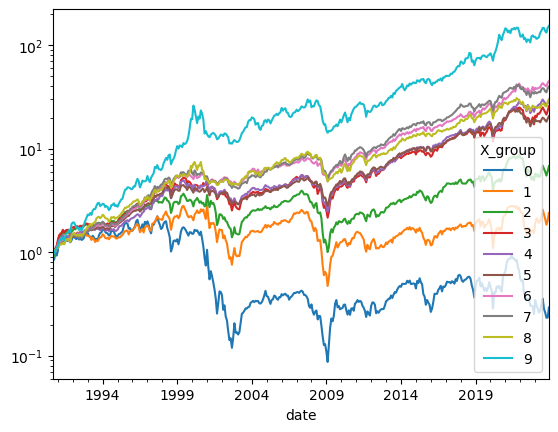

In [20]:
def returnbyX(df,y='ret',X='value',ngroups=10,plot=True):
    df['X_group']=df.groupby(['date'])[X].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
    ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())
    ret=ret.unstack(level=-1)
    if plot:
        if y=='ret':
            (ret+1).cumprod().plot(logy=True)
        else:
            ret.plot()
    return ret


returnbyX(df,y='ret',X='mom',ngroups=10,plot=True)


Note that this sample is after the momentum paper we published, so it is true out of sample.

> ### Wrapping all in a function that goes from the Return/market cap data to the final signal-sorted portfolio
> Things to try
> - Play with different look-back windows
> - Play with how many months to skip (1 is the minimum to make the strategy valid. 2 is the standard.)
>       - What do you think it will happen if you don't skip and let the signal overlap with the return data?
>       - What happens if you skip more months?
> - What happens if you sort only on the month that the standard momentum skips?
> - what if you sort on very long-term momentum, like 60 months?
> - Cumulative returns is just one possible moment to look at
>   - What about volatility?
>   - What about covariance with the market?
>   - What about maximum/minimum return?

In [26]:
# put it all together in a fuction
def momentum(df,ngroups=10,lookback=11,extraskip=1):
    df['1+ret']=(df['ret']+1)
    df=df.set_index(['date'])
    temp=(df.groupby('permno')[['1+ret']]).rolling(window=lookback,min_periods=lookback).apply(np.prod, raw=True)
    temp=temp.rename(columns={'1+ret':'signal_contemp'})
    temp =temp.reset_index()
    df = pd.merge(df.reset_index(), temp[['permno','date','signal_contemp']], how='left', on=['permno','date'])
    df=df.sort_values(['date','permno'])
    df['me_l1']=df.groupby('permno')['me'].shift(1)
    df['signal']=df.groupby('permno')['signal_contemp'].shift(1+extraskip)
    df=df.dropna(subset=['signal'], how='any')
    ret=returnbyX(df,y='ret',X='signal',ngroups=10,plot=True)
    
    return ret
    

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_19288\3636907694.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())


X_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1991-01-31,0.113977,0.123368,0.121564,0.134447,0.086775,0.056062,0.054355,0.028442,0.021337,0.067651
1991-02-28,0.342850,0.176918,0.135603,0.112137,0.084677,0.073092,0.069951,0.064866,0.062943,0.095270
1991-03-31,0.062126,0.061158,0.041783,0.014742,0.038475,0.011460,0.017723,0.026697,0.024460,0.068706
1991-04-30,0.018582,-0.008934,0.016253,0.030825,0.034372,-0.009351,0.016612,0.009086,-0.010582,-0.015520
1991-05-31,-0.075714,0.023718,0.083954,0.070792,0.048429,0.046285,0.038407,0.029638,0.040514,0.044975
...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.200407,-0.099046,-0.071375,-0.053064,-0.044406,-0.019954,-0.028805,-0.015799,0.006243,-0.002667
2023-09-30,-0.075222,-0.098350,-0.058665,-0.057555,-0.030818,-0.046053,-0.024102,-0.055529,-0.045170,-0.064867
2023-10-31,-0.112877,-0.120038,-0.084968,-0.047023,-0.043967,-0.033107,-0.018236,-0.020657,-0.013869,-0.033726


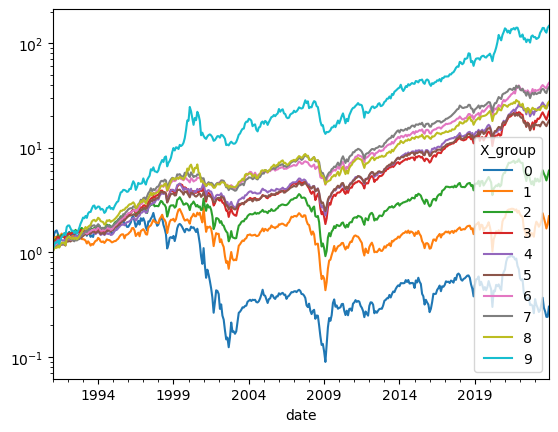

In [27]:
momentum(crsp,ngroups=10,lookback=11,extraskip=1)


**Past Cross-sectional Return Predictability a summary**

1. Long-term reversals
   - DeBondt and Thaler (1985)
   - 3-5 year contrarian strategy

2. Short-term (< 1 month) reversals
   - Jegadeesh (1990), Lehman (1990), Lo andMacKinlay (1988)

3. Intermediate horizon continuation
   - Jegadeesh and Titman (1993)
   - 3-12 month momentum strategy
   - profits dissipate over 1-year and start to reverse after 2-3 years -> temporary price effect.
   - see similar pattern around earnings announcements (both earnings and price momentum).



**Why this might work?**


* Behavioral view: The idea here is that markets might be slow to incorporate information, so good/bad news gets into prices slowly over time. For example investors might only slowly get into prices the consequences of a Trump second term. 

* Rational view: Maybe all these stocks are exposed to the same missing risk-factor. They all went up and down at the same time after all! For example all firms that went down in march 2020 are particularly exposed to Covid and the ones that did well are positively exposed. So they will move together as COVID risk fluctuate. It is hard to use a story like that to explain the premium, but it is easy to see how it explains the co-movement.

* My overall sense is that the majority of academics think that momentum is driven by "behavioral" factors. Note however that momentum tends to crash very badly in high volatility periods such as 2008 and 2020, so it is certainly risky if you zoom out a bit.

**Literature**

Lots of work on this. 

1. [Here is a review of the work on the momentum strategy](https://www.annualreviews.org/doi/full/10.1146/annurev-financial-102710-144850)


2. [Here is the paper that first documented the Momentum profitability](https://www.jstor.org/stable/pdf/2328882.pdf?casa_token=wjU0QYjZvg4AAAAA:aAxgJJLpR7VexgbmcWBBUMveRXin7d5VpGkrYIXDm_UseOs_ETYRZWSNLHzmkGrDFk5A4PNvA6nI8JY4k5khKlSDucppwJ1JNlx0GGqQthOQ4uBY6cA)

3. [Here is Daniel and Moskowitz analysis of momentum](https://github.com/amoreira2/Lectures/blob/a1f2e6ef36e80d32ee12a391b878f564f15c3cd5/assets/papers/Daniel%20Moskowitz%202015.pdf)


**Other "returns" based strategies**

One can easily adapt the code to reproduce a variety of investment strategies that only rely on return information, broadly described as "technical" strategies

1. Short-term Reversals: Sort stocks based on returns in month t-1, but in the beggining of month t

2. Long-term reversals: Sort on cumulative returns of the last 5 years

3. Volatility: sort on the return volatiltiy of the last 24 months, say using returns between t-24 to t-1 and form the portfolio in beggining of date t.

4. (HARDER) Market beta: Sort stocks based on their beta with the market porfolio. Say estimate beta using the last 60 months of data (t-60 to t-1) and form portfolio at the beggining of date t.

Below is a plot that summarizes the emprical evidence on return-based strategies. It shows the Sharpe Ratio as a function of the lookback period of the reutrn signal


![image.png](https://github.com/amoreira2/Lectures/raw/main/assets/plots/momentum1.jpg)

* Can you reproduce this plot?